In [83]:
import requests

In [86]:
robots_txt = requests.get("https://www.newsday.com/robots.txt")
robots_txt.content.decode("utf-8").split('\n')

['User-agent: *  ',
 'Disallow: /preview/',
 'Disallow: /iosfeeds/',
 'Disallow: /json/',
 'Disallow: /cmlink/ ',
 'Disallow: /mobile/',
 'Disallow: /5819/',
 'Disallow: *?lng',
 'Disallow: *?view',
 '',
 '',
 'Sitemap: https://www.newsday.com/sitemap/',
 'Sitemap: https://projects.newsday.com/sitemap_index.xml',
 'Sitemap: https://projects.newsday.com/voters-guide/sitemap.xml',
 'Sitemap: https://projects.newsday.com/schools/sitemap.xml',
 'Sitemap: https://projects.newsday.com/payrolls/sitemap_index.xml']

In [87]:
sitemap_locs = requests.get("https://www.newsday.com/sitemap")

Looking at the return, we can see what appears to be a sitemap by month. It doesn't include the latest months, which is kind of interesting. Not sure why that should be. The document is an XML doc, so we can parse it and work through it as desired. 

In [88]:
import xml.etree.ElementTree as etree
sitemap_doc = etree.fromstring(sitemap_locs.content.decode("utf-8"))

In [239]:
loc = sitemap_doc[0]

In [240]:
loc[0].text

'https://www.newsday.com/sitemap/article/2022/5'

Let's build the set of every article we can get from the sitemap (we are not going to pull all of them)

In [247]:
sitemap_urls = [loc[0].text for loc in sitemap_doc if "article" in loc[0].text]

In [250]:
import uuid

In [252]:
str(uuid.uuid4())

'a4e18863-4cbd-4b13-976e-7d7f051f0c33'

In [256]:
u.split('/')[-2]

'2013'

In [261]:
"1".rjust(2, "0")

'01'

In [262]:
import uuid 

for u in sitemap_urls:
    m = requests.get(u)
    if m.ok:
        fields = u.split('/')
        file_name = fields[-2] + fields[-1].rjust(2, "0") + ".xml"
        if int(fields[-2]) >= 2012:
            file_path = os.path.join("/workspaces/long-island-digest/data/raw/newsday/sitemaps", file_name)
            with open(file_path, "wb") as fout:
                fout.write(m.content)



In [264]:
from glob import glob

In [265]:
sitemap_files = glob("/workspaces/long-island-digest/data/raw/newsday/sitemaps/*.xml")

In [275]:
sitemap_frames = []

for smf in sitemap_files:
    sitemap_df = pd.read_xml(smf)
    file_name = os.path.split(smf)[1]
    file_month = os.path.splitext(file_name)[0]
    sitemap_df['YearMonth'] = pd.to_datetime(file_month, format="%Y%m")
    sitemap_frames.append(sitemap_df)

Fun with Pandas - remove duplicates! 

In [331]:
sitemap_df = pd.concat(sitemap_frames).drop_duplicates()
sitemap_df = sitemap_df.rename(columns={"loc": "url"})
sitemap_df

,url,changefreq,priority,YearMonth
0,https://www.newsday.com/sports/basketball/knic...,monthly,0.9,2012-01-01
1,https://www.newsday.com/news/keeler-gingrich-s...,monthly,0.9,2012-01-01
2,https://www.newsday.com/business/best-january-...,monthly,0.9,2012-01-01
3,https://www.newsday.com/sports/boxing/hbo-spor...,monthly,0.9,2012-01-01
4,https://www.newsday.com/sports/football/giants...,monthly,0.9,2012-01-01
...,...,...,...,...
1785,https://www.newsday.com/sports/columnists/bob-...,monthly,0.9,2022-05-01
1786,https://www.newsday.com/sports/high-school/boy...,monthly,0.9,2022-05-01
1787,https://www.newsday.com/sports/baseball/yankee...,monthly,0.9,2022-05-01
1788,https://www.newsday.com/sports/high-school/tra...,monthly,0.9,2022-05-01


One of the things we can notice is that the practice of adding a section and subsection is not universal. Sometimes there is only a section with the rest of it missing. 

In [332]:
urls = sitemap_df['url'].values
sections = [u.split('/')[3] for u in urls]
subsections = [u.split('/')[4] for u in urls if len(u.split('/')) > 4]
subsubsections = [u.split('/')[5] for u in urls if len(u.split('/')) > 5] 
sections_counter = Counter(sections)
subsections_counter = Counter(subsections)
subsubsections_counter = Counter(subsubsections)

In [334]:
valid_sections = [s for s in sections_counter if sections_counter.get(s) > 1]
valid_subsections = [s for s in subsections_counter if subsections_counter.get(s) > 1]
valid_subsubsections = [s for s in subsubsections_counter if subsubsections_counter.get(s) > 1]

In [355]:
sections = ["/".join(u.split("/")[3:-1]) for u in urls]

In [363]:
sections_counter = Counter(sections)

In [340]:
def get_section(url):
    fields = url.split("/")
    if len(fields) >= 3:
        if fields[3] in valid_sections:
            return fields[3]
    return "Unknown"

def get_

In [366]:
sitemap_df['sections'] = sitemap_df['url'].apply(lambda x: "/".join(x.split("/")[3:-1]))
sitemap_df['valid_sections'] = sitemap_df['sections'].apply(lambda x: x if sections_counter.get(x) > 1 else 'Unknown')
sitemap_df['valid_sections'] = sitemap_df['valid_sections'].str.split('/')
sitemap_df

,url,changefreq,priority,YearMonth,section,sections,valid_sections
0,https://www.newsday.com/sports/basketball/knic...,monthly,0.9,2012-01-01,sports,sports/basketball/knicks,"[sports, basketball, knicks]"
1,https://www.newsday.com/news/keeler-gingrich-s...,monthly,0.9,2012-01-01,news,news,[news]
2,https://www.newsday.com/business/best-january-...,monthly,0.9,2012-01-01,business,business,[business]
3,https://www.newsday.com/sports/boxing/hbo-spor...,monthly,0.9,2012-01-01,sports,sports/boxing,"[sports, boxing]"
4,https://www.newsday.com/sports/football/giants...,monthly,0.9,2012-01-01,sports,sports/football/giants,"[sports, football, giants]"
...,...,...,...,...,...,...,...
1785,https://www.newsday.com/sports/columnists/bob-...,monthly,0.9,2022-05-01,sports,sports/columnists/bob-glauber,"[sports, columnists, bob-glauber]"
1786,https://www.newsday.com/sports/high-school/boy...,monthly,0.9,2022-05-01,sports,sports/high-school/boys-lacrosse,"[sports, high-school, boys-lacrosse]"
1787,https://www.newsday.com/sports/baseball/yankee...,monthly,0.9,2022-05-01,sports,sports/baseball/yankees,"[sports, baseball, yankees]"
1788,https://www.newsday.com/sports/high-school/tra...,monthly,0.9,2022-05-01,sports,sports/high-school/track,"[sports, high-school, track]"


In [385]:
sections_df = pd.DataFrame(sitemap_df['valid_sections'].tolist())
sections_df.columns = ['L1', 'L2', 'L3', 'L4']
sitemap_df.merge(sections_df, left_index=True, right_index=True)

,url,changefreq,priority,YearMonth,section,sections,valid_sections,L1,L2,L3,L4
0,https://www.newsday.com/sports/basketball/knic...,monthly,0.9,2012-01-01,sports,sports/basketball/knicks,"[sports, basketball, knicks]",sports,basketball,knicks,None
0,https://www.newsday.com/news/new-york/kelly-be...,monthly,0.9,2012-02-01,news,news/new-york,"[news, new-york]",sports,basketball,knicks,None
0,https://www.newsday.com/news/world/review-targ...,monthly,0.9,2012-03-01,news,news/world,"[news, world]",sports,basketball,knicks,None
0,https://www.newsday.com/opinion/feud-unproduct...,monthly,0.9,2012-04-01,opinion,opinion,[opinion],sports,basketball,knicks,None
0,https://www.newsday.com/sports/football/jets/u...,monthly,0.9,2012-05-01,sports,sports/football/jets,"[sports, football, jets]",sports,basketball,knicks,None
...,...,...,...,...,...,...,...,...,...,...,...
5727,https://www.newsday.com/news/region-state/indi...,monthly,0.9,2012-03-01,news,news/region-state,"[news, region-state]",news,new-york,None,None
5728,https://www.newsday.com/sports/soccer/u-s-notc...,monthly,0.9,2012-03-01,sports,sports/soccer,"[sports, soccer]",sports,high-school,boys-basketball,None
5729,https://www.newsday.com/long-island/suffolk/2-...,monthly,0.9,2012-03-01,long-island,long-island/suffolk,"[long-island, suffolk]",sports,baseball,mets,None
5730,https://www.newsday.com/entertainment/theater/...,monthly,0.9,2012-03-01,entertainment,entertainment/theater,"[entertainment, theater]",news,nation,None,None


In [386]:
sitemap_df.iloc[5727]

url               https://www.newsday.com/news/new-york/buy-a-mi...
changefreq                                                  monthly
priority                                                        0.9
YearMonth                                       2012-02-01 00:00:00
section                                                        news
sections                                              news/new-york
valid_sections                                     [news, new-york]
Name: 555, dtype: object

We can see that obituaries were at one point moved under their own section of coronavirus news. That's heartbreaking. 

In [375]:
sections = pd.DataFrame(sitemap_df['valid_sections'].tolist())

In [383]:
sections[sections[3]=='obituaries']

,0,1,2,3
326214,news,health,coronavirus,obituaries
326223,news,health,coronavirus,obituaries
326226,news,health,coronavirus,obituaries
326259,news,health,coronavirus,obituaries
326260,news,health,coronavirus,obituaries
...,...,...,...,...
346688,news,health,coronavirus,obituaries
346691,news,health,coronavirus,obituaries
346814,news,health,coronavirus,obituaries
350188,news,health,coronavirus,obituaries


In [341]:
sitemap_df['section'] = sitemap_df['url'].apply(get_section)

In [343]:
sitemap_df['section'].value_counts()

sports             100911
long-island         79971
news                68850
opinion             31013
entertainment       30119
lifestyle           28858
business            20317
classifieds          8668
travel               1169
services              128
911-anniversary       114
Unknown                 4
Name: section, dtype: int64

In [320]:
sitemap_df[sitemap_df['loc'].str.contains("newsday-llc-privacy-policy-fasg61nc")]

,loc,changefreq,priority,YearMonth,section,subsection
1207,https://www.newsday.com/services/newsday-llc-p...,monthly,0.9,2022-02-01,services,newsday-llc-privacy-policy-fasg61nc
1208,https://www.newsday.com/services/newsday-llc-p...,monthly,0.9,2022-02-01,services,newsday-llc-privacy-policy-fasg61nc


Under these loc tags are actual article locations. These will let us see and download the raw html text of the articles. 

In [92]:
article_urls = etree.fromstring(m.content.decode("utf-8"))
article_urls

<Element '{http://www.sitemaps.org/schemas/sitemap/0.9}urlset' at 0x7fcdf8ae9ad0>

In [117]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.4 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [98]:
from collections import Counter

We can see something interesting just looking at the sections identified by the url; Sports outnumbers the second most common section (long-island) by 2:1! 

In [128]:
for i, f in enumerate(u[0].text.split('/')):
    print(i, f)

0 https:
1 
2 www.newsday.com
3 long-island
4 suffolk
5 protest-off-key-tikki-bar-cinco-de-mayo-patchogue-rgfnh3o1


In [120]:
len(u[0].text.split('/'))

6

In [116]:
Counter(sub_sections)

Counter({'college': 34,
         'nassau': 46,
         'education': 21,
         'baseball': 206,
         'high-school': 127,
         'suffolk': 69,
         'region-state': 28,
         'columnists': 83,
         'hockey': 144,
         'editorials': 26,
         'the-point': 21,
         'lgbtq-pride-month-h4rgvviq': 1,
         'golf': 19,
         'football': 54,
         'weather': 33,
         'transportation': 8,
         'celebrities': 25,
         'crime': 81,
         'media': 15,
         'womens-sports': 19,
         'soccer': 31,
         'long-island-events': 14,
         'commentary': 34,
         'tennis': 18,
         'letters': 31,
         'restaurants': 27,
         'prologis-warehouse-grumman-bethpage-ida-tax-breaks-ttb53zl8': 1,
         'jersey-mikes-subs-bohemia-normandie-inn-torn-down-wul8jes1': 1,
         'real-estate': 22,
         'tv': 35,
         'new-york': 16,
         'family': 12,
         'horse-racing': 35,
         'ground-zero-recovery-anniver

In [113]:
Counter(sections)

Counter({'sports': 862,
         'long-island': 355,
         'news': 120,
         'opinion': 135,
         'entertainment': 116,
         'lifestyle': 101,
         'business': 65,
         'classifieds': 22,
         '911-anniversary': 1,
         'travel': 13})

In [124]:
sections = []
sub_sections = []
larger = []
for u in article_urls:
    sections.append(u[0].text.split('/')[3])
    sub_sections.append(u[0].text.split('/')[4])
    if len(u[0].text.split('/')) > 6:
        larger.append(u[0].text)
    if len(u[0].text.split('/')) > 7:
        print(u[0].text)

In [197]:
articles_df.columns=['source', 'target', 'weight']

In [198]:
import networkx as nx

In [205]:
G = nx.from_pandas_edgelist(articles_df, edge_attr="weight", create_using=nx.DiGraph())

In [209]:
G['sports']

AtlasView({'college': {'weight': 34}, 'baseball': {'weight': 206}, 'high-school': {'weight': 127}, 'hockey': {'weight': 144}, 'columnists': {'weight': 54}, 'golf': {'weight': 19}, 'football': {'weight': 54}, 'media': {'weight': 15}, 'womens-sports': {'weight': 19}, 'soccer': {'weight': 31}, 'tennis': {'weight': 18}, 'horse-racing': {'weight': 35}, 'basketball': {'weight': 65}, 'motor-racing': {'weight': 6}, 'boxing': {'weight': 13}, 'mixed-martial-arts': {'weight': 11}, 'local': {'weight': 5}})

In [211]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 13.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.4/950.4 KB 14.3 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


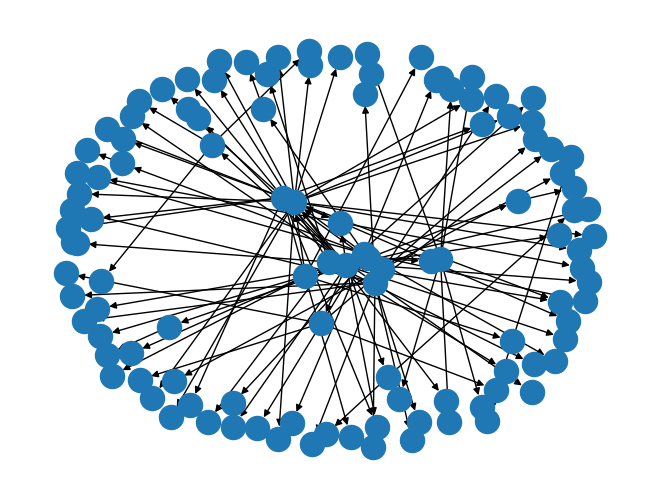

In [212]:
nx.draw(G)

In [213]:
%pip install anytree

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 2.5 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [232]:
from anytree import Node, RenderTree

root = Node("newsday")
nodes = dict()

for k in c.keys():
    n = Node(k[1], parent=root)
    nodes[k[1]] = n

In [236]:
nodes[k[0]]

Node('/newsday/sports')

In [233]:
nodes

{'sports': Node('/newsday/sports'),
 'long-island': Node('/newsday/long-island'),
 'news': Node('/newsday/news'),
 'opinion': Node('/newsday/opinion'),
 'entertainment': Node('/newsday/entertainment'),
 'lifestyle': Node('/newsday/lifestyle'),
 'business': Node('/newsday/business'),
 'classifieds': Node('/newsday/classifieds'),
 '911-anniversary': Node('/newsday/911-anniversary'),
 'travel': Node('/newsday/travel')}

In [237]:
for k in e.keys():
    n = Node(k[1], parent=nodes[k[0]])
    nodes[k[1]] = n

In [238]:
import anytree
print(RenderTree(root, style=anytree.render.AsciiStyle()))

Node('/newsday')
|-- Node('/newsday/sports')
|   |-- Node('/newsday/sports/college')
|   |   |-- Node('/newsday/sports/college/college-football')
|   |   |-- Node('/newsday/sports/college/hofstra')
|   |   |-- Node('/newsday/sports/college/stony-brook')
|   |   +-- Node('/newsday/sports/college/college-basketball')
|   |-- Node('/newsday/sports/baseball')
|   |   |-- Node('/newsday/sports/baseball/mets')
|   |   +-- Node('/newsday/sports/baseball/yankees')
|   |-- Node('/newsday/sports/high-school')
|   |   |-- Node('/newsday/sports/high-school/baseball')
|   |   |-- Node('/newsday/sports/high-school/softball')
|   |   |-- Node('/newsday/sports/high-school/track')
|   |   |-- Node('/newsday/sports/high-school/boys-lacrosse')
|   |   |-- Node('/newsday/sports/high-school/girls-lacrosse')
|   |   |-- Node('/newsday/sports/high-school/football')
|   |   |-- Node('/newsday/sports/high-school/tennis')
|   |   |-- Node('/newsday/sports/high-school/badminton')
|   |   |-- Node('/newsday/sport

In [109]:
u[0].text

'https://www.newsday.com/long-island/suffolk/protest-off-key-tikki-bar-cinco-de-mayo-patchogue-rgfnh3o1'

In [52]:
(_, _, _, section, subsection, article) = u[0].text.split('/')

In [56]:
print(section, subsection, article)

long-island suffolk protest-off-key-tikki-bar-cinco-de-mayo-patchogue-rgfnh3o1


In [135]:
# build a dataframe? Can we apply the function to each record in parallel? 
fields = u[0].text.split('/')
fields

['https:',
 '',
 'www.newsday.com',
 'long-island',
 'suffolk',
 'protest-off-key-tikki-bar-cinco-de-mayo-patchogue-rgfnh3o1']

In [136]:
# have to reduce them two at a time
for z in zip(fields[3:-1], fields[4:-1]):
    print(z)

('long-island', 'suffolk')


In [143]:
# alright then... 
sections = []
for u in article_urls:
    fields = u[0].text.split('/')
    sections.append(("newsday", fields[3]))


In [147]:
c = Counter(sections)
c

Counter({('newsday', 'sports'): 862,
         ('newsday', 'long-island'): 355,
         ('newsday', 'news'): 120,
         ('newsday', 'opinion'): 135,
         ('newsday', 'entertainment'): 116,
         ('newsday', 'lifestyle'): 101,
         ('newsday', 'business'): 65,
         ('newsday', 'classifieds'): 22,
         ('newsday', '911-anniversary'): 1,
         ('newsday', 'travel'): 13})

In [164]:
# assemble parents and children
edges = []

articles = []
for u in article_urls:
    fields = u[0].text.split('/')
    for z in zip(fields[3:-1], fields[4:-1]):
        edges.append(z)

e = Counter(edges)
edges_df = pd.DataFrame(e.keys())
edges_df['Values'] = e.values()

In [152]:
df = pd.DataFrame(c.keys())
df['Values'] = c.values()
df

,0,1,Values
0,newsday,sports,862
1,newsday,long-island,355
2,newsday,news,120
3,newsday,opinion,135
4,newsday,entertainment,116
5,newsday,lifestyle,101
6,newsday,business,65
7,newsday,classifieds,22
8,newsday,911-anniversary,1
9,newsday,travel,13


In [167]:
articles_df = pd.concat([df, edges_df])

In [170]:
articles_df.columns = ['Parent', 'Child', 'Values']
articles_df

,Parent,Child,Values
0,newsday,sports,862
1,newsday,long-island,355
2,newsday,news,120
3,newsday,opinion,135
4,newsday,entertainment,116
...,...,...,...
103,columnists,michael-dobie,3
104,columnists,anthony-rieber,2
105,basketball,nets,3
106,opinion,voices,1


In [195]:
articles_df.Parent.value_counts()

sports           17
columnists       16
long-island      12
high-school      11
newsday          10
lifestyle         8
news              7
opinion           6
entertainment     6
college           4
basketball        3
business          2
hockey            2
football          2
baseball          2
commentary        2
local             1
soccer            1
travel            1
holidays          1
restaurants       1
health            1
classifieds       1
education         1
Name: Parent, dtype: int64

In [175]:
articles_df.query("""Parent=='sports'""")['Values'].sum()

856

In [156]:
import plotly.express as px

In [189]:

fig = px.treemap(
    articles_df,
    names='Child',
    parents='Parent',
    values='Values',
    maxdepth=-1
)
fig.show()

In [194]:
import plotly.graph_objects as go

fig = go.Figure(go.Treemap(
    labels=articles_df.query("Parent=='long-island'")['Child'],
    parents=articles_df.query("Parent=='long-island'")['Parent'],
    values=articles_df.query("Parent=='long-island'")['Values']
))
fig.show()

In [142]:
%pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 9.7 MB/s eta 0:00:00:00:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [141]:
import pandas as pd
pd.DataFrame(edges)

,0,1
0,sports,college
1,long-island,nassau
2,long-island,education
3,long-island,nassau
4,sports,baseball
...,...,...
2249,sports,baseball
2250,baseball,yankees
2251,sports,high-school
2252,high-school,track


In [140]:
fields

['https:',
 '',
 'www.newsday.com',
 'long-island',
 'suffolk',
 'protest-off-key-tikki-bar-cinco-de-mayo-patchogue-rgfnh3o1']

In [139]:
Counter(edges)

Counter({('sports', 'college'): 34,
         ('long-island', 'nassau'): 46,
         ('long-island', 'education'): 21,
         ('sports', 'baseball'): 206,
         ('baseball', 'mets'): 82,
         ('baseball', 'yankees'): 81,
         ('sports', 'high-school'): 127,
         ('high-school', 'baseball'): 37,
         ('long-island', 'suffolk'): 69,
         ('news', 'region-state'): 28,
         ('opinion', 'columnists'): 22,
         ('columnists', 'randi-f-marshall'): 5,
         ('sports', 'hockey'): 144,
         ('hockey', 'rangers'): 79,
         ('opinion', 'editorials'): 26,
         ('sports', 'columnists'): 54,
         ('columnists', 'andrew-gross'): 9,
         ('opinion', 'the-point'): 21,
         ('sports', 'golf'): 19,
         ('sports', 'football'): 54,
         ('football', 'giants'): 23,
         ('news', 'weather'): 33,
         ('long-island', 'transportation'): 8,
         ('entertainment', 'celebrities'): 25,
         ('college', 'college-football'): 6,
     

In [65]:
import pandas as pd
articles_df = pd.DataFrame(articles)

In [66]:
def download_text(url):
    response = requests.get(url)
    if response == 200:
        return response.content.decode("utf-8")

In [79]:
response.ok

True

In [76]:
article_path = os.path.join("/workspaces/long-island-digest/data/raw/newsday/2022-05", f"{row['article']}.html")

'/workspaces/long-island-digest/data/raw/newsday/2022-05/nys-local-elections-turnout-ijy7ye2r.html'

In [82]:
import os
for i, row in articles_df.iterrows():
    response = requests.get(row['url'])
    if response.ok:
        article_path = os.path.join("/workspaces/long-island-digest/data/raw/newsday/2022-05", f"{row['article']}.html")
        with open(article_path, "wb") as fout:
            fout.write(response.content)
        


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [67]:
articles_df['html'] = articles_df['url'].apply(download_text)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [68]:
articles_df

,url,section,subsection,article
0,https://www.newsday.com/sports/college/aidan-k...,sports,college,aidan-kaminska-port-jefferson-umass-lacrosse-w...
1,https://www.newsday.com/long-island/nassau/bet...,long-island,nassau,bethpage-man-dies-struck-sedan-vepizees
2,https://www.newsday.com/long-island/education/...,long-island,education,relaxed-rules-regents-exams-u8seogt6
3,https://www.newsday.com/long-island/nassau/nif...,long-island,nassau,nifa-nassau-county-employee-longevity-pay-jwp4...
4,https://www.newsday.com/sports/baseball/mets/j...,sports,baseball,johan-santana-no-hitter-terry-collins-mets-c4i...
...,...,...,...,...
1785,https://www.newsday.com/sports/columnists/bob-...,sports,columnists,jets-nfl-draft-joe-douglas-w5c3bfk6
1786,https://www.newsday.com/sports/high-school/boy...,sports,high-school,high-school-boys-lacrosse-ukufxvn4
1787,https://www.newsday.com/sports/baseball/yankee...,sports,baseball,yankees-p119yvsl
1788,https://www.newsday.com/sports/high-school/tra...,sports,high-school,high-school-track-j9kex1ci
